CS 615 Final Project
Submission Date: 3/20/2025
William Lien, Shawn Thomas, Shobhit Dixit, Rutvij Upadhyay

This notebook hosts 4 seperate CNN models. For any model usage, run the PARAMETERS and LOAD DATASET sections.

While a consolidated framework would have been more convienent, setbacks in the standardization lead to each model hosting a different framework depending on the needs.

The next four sections host different models (base, multi-kernel, RGB, and multi-CNN layer), alongside the functions to load images in the correct color settings, and framework specifically to run that model. These should at the time of submission hold the final loss and accuracy graphs for each run.




#Parameters

##Image Size Parameters




In [1]:
H = 80 # @param {"type":"integer"}
W = 80 # @param {"type":"integer"}

##Dataset Parameters


In [2]:
trainTrue = 88 # @param {"type":"integer"}
trainFalse = 112 # @param {"type":"integer"}
testTrue = 25 # @param {"type":"integer"}
testFalse = 25 # @param {"type":"integer"}



##Learning Rate Parameters

In [3]:
FCLearn = .0025 # @param {"type":"number"}
KLearn = .0025 # @param {"type":"number"}

##Kernel,Max-pool, FC Parameters

In [4]:
kSize = 5 # @param {"type":"integer"}
numKernels = 3 # @param {"type":"integer"}
mpSize = 2 # @param {"type":"integer"}
mpStride = 2 # @param {"type":"integer"}
weightOut = 1 # @param {"type":"integer"}

##Epochs

In [5]:
epochs = 250 # @param {"type":"integer"}

#Load Dataset

In [6]:
import kagglehub
import numpy as np
import math
from scipy import signal
from abc import ABC, abstractmethod
import random
import sys
import os
from PIL import Image
import matplotlib.pyplot as plt
import time
import os
fpath = kagglehub.dataset_download("tusharpadhy/deepfake-dataset")

100%|██████████| 5.42G/5.42G [01:10<00:00, 82.9MB/s]

Extracting files...


#Base Model - Greyscale, 1 CNN, 1 Kernel

##Framework

In [ ]:
import numpy as np
import math
from scipy import signal
from abc import ABC, abstractmethod
import random
import sys
import os
from PIL import Image
import matplotlib.pyplot as plt
import time

##########BASE CLASS###########
class Layer(ABC):
  def __init__(self):
    self.__prevIn = []
    self.__prevOut = []

  def setPrevIn(self,dataIn):
    self.__prevIn = dataIn

  def setPrevOut(self, out):
    self.__prevOut = out

  def getPrevIn(self):
    return self.__prevIn

  def getPrevOut(self):
    return self.__prevOut

  """
  def backward(self, gradIn):
    sg = self.gradient()
    gradOut = np.zeros((gradIn.shape[0],sg.shape[2]))

    for n in range(gradIn.shape[0]):
        gradOut[n] = np.atleast_2d(gradIn[n])@sg[n]
    return gradOut
  """
  def backward(self,gradIn):
    #from lecture slides:

    #sg = self.gradient()
    #gradOut = np.zeros((gradIn.shape[0],sg.shape[1]))
    #for i in range(gradIn.shape[0]):
    #  gradOut[i] = np.atleast_2d(gradIn[i])@np.atleast_2d(sg[i])
    #  return gradOut


    sg = self.gradient()

    if(sg.ndim == 3):  #tensor coming back
        gradOut = np.zeros((gradIn.shape[0],sg.shape[2]))
        for i in range(gradIn.shape[0]):
            gradOut[i] = np.atleast_2d(gradIn[i])@np.atleast_2d(sg[i])
    else:
        gradOut = np.atleast_2d(gradIn)@sg

    return gradOut

  @abstractmethod
  def forward(self,dataIn):
    pass

  @abstractmethod
  def gradient(self):
    pass

##########BASE CLASS###########
class Objective(ABC):
    def __init__(self):
        pass

    @abstractmethod
    def eval(Y,Yhat):
        pass

    @abstractmethod
    def gradient(Y,Yhat):
        pass


#\/\/\/\/CONVOLUTION\/\/\/\/
class ConvolutionalLayer(Layer):

    '''Constructor (init)- Your constructor should take in a single
    explicit parameter, the kernel size.
    We will assume the kernel is square, of an odd size,
    and that will have a single kernel '''

    def __init__(self, kernelSize):
        super().__init__()
        #is zeros right?
        #check for odd number size?
        a = -1e-1
        b = 1e-1
        self.kernel = np.random.uniform(a, b, (kernelSize, kernelSize))


    def setKernels(self,K):
        '''- This method should take a matrix (or tensor) as a parameter
        and set the weights of the kernel(s) to it. '''

        self.kernel = K

    def getKernels(self):
        #This returns the kernel(s).
        return self.kernel

    @staticmethod
    def crossCorrelate2D(K,N):
        '''This static method should take two matrices as parameters,
        and return their cross-correlation. You do not need to support padding.'''
        N_height, N_width = N.shape
        K_height, K_width = K.shape

        result_height = N_height - K_height + 1
        result_width = N_width - K_width + 1

        result = np.zeros((result_height, result_width))

        for i in range(result_height):
            for j in range(result_width):
                submatrix = N[i: i+K_height, j: j+K_width]
                result[i, j] = np.sum(submatrix * K)


        return result


    def forward(self,X):
        '''This method should take a tensor of incoming data (N × H × W),
        set prevIn with it, compute the cross-correlation of
        each observations with the kernel,
        store this result with its parent class (prevOut)
        and return it (this output should also be a tensor). '''
        self.setPrevIn(X)
        N,H,W = X.shape
        outputs = []

        for i in range(N):

            result = ConvolutionalLayer.crossCorrelate2D(self.kernel,X[i])

            outputs.append(result)

        result = np.stack(outputs,axis=0)
        self.setPrevOut(result)
        return result


    def gradient(self):
        pass

    def backward(self):
        pass

    def updateKernels(self,backGrad,eta):
        X = self.getPrevIn()
        N, H, W = X.shape

        kernelGrad = np.zeros(self.kernel.shape,dtype='float64')


        for n in range(N):
            for i in range(H - self.kernel.shape[0] + 1):
                for j in range(W - self.kernel.shape[1] + 1):
                    input_patch = X[n, i:i + self.kernel.shape[0], j:j + self.kernel.shape[1]]

                    kernelGrad += input_patch * backGrad[n, i, j]


        self.kernel = self.kernel -  eta * kernelGrad

#\/\/\/\/Cross Entropy\/\/\/\/

class CrossEntropy(Objective):
    def eval(self,Y,Yhat):
        constant = 10**-7
        tmp = Y*np.log(Yhat+constant)
        return -np.mean(np.sum(tmp,axis=1))



    def gradient(self,Y,Yhat):
        constant = 10e-7
        return -(Y/(Yhat + constant))


#\/\/\/\/Flatten\/\/\/\/
class FlatteningLayer(Layer):
    def __init__(self):
        super().__init__()

    def forward(self, X):
        self.setPrevIn(X)

        N,H,W = X.shape
        flatten = X.reshape(N,-1,order="F")

        self.setPrevOut(flatten)
        return flatten

    def gradient(self):
        pass

    def backward(self,gradIn):
        #return original dimensions
        N,H,W = self.getPrevIn().shape

        gradOut = gradIn.reshape(N,H,W, order="F")

        return gradOut

    def backward2(self,gradIn):
        #return original dimensions
        #copy -- all other functions for Q2 have a backward 2 method, this makes it easier without messing with the test script
        N,H,W = self.getPrevIn().shape

        gradOut = gradIn.reshape(N,H,W, order="F")

        return gradOut


#\/\/\/\/FullyConnected\/\/\/\/
class FullyConnectedLayer(Layer):
     #Input : sizeIn , the number of features of data coming in
    # #Input : sizeOut , the number of features for the data coming out.
    # #Output: None

    def __init__(self, sizeIn, sizeOut,useBias=0):
        super().__init__()
        #useBias needed for test, unsure where it fits in this setup

        #initialize weight and bias
        #Xaiver
        a =  -(6/(sizeIn+sizeOut))**(1/2)
        b = (6/(sizeIn+sizeOut))**(1/2)
        self.W = np.random.uniform(a, b, (sizeIn, sizeOut))
        self.B = np.random.uniform(a, b, (1, sizeOut))

     #  #Input : None
    # #Output: The (sizeIn by sizeOut) weight matrix.
    def getWeights(self):
        return self.W

    # #Input : The (sizeIn by sizeOut) weight matrix.
    # #Output: None
    def setWeights(self, weights):
        self.W = weights


     # #Input : None
    # #Output: The (1 by sizeOut) bias vector
    def getBiases(self):
        return self.B

     # #Input : The (1 by sizeOut) bias vector
    # #Output: None
    def setBiases(self, biases):
        self.B = biases

     # #Input : dataIn , a (1 by D) data matrix
    # #Output: A (1 by K) data matrix
    def forward(self, dataIn):

        self.setPrevIn(dataIn)
        Y = np.dot(dataIn, self.W) + self.B
        self.setPrevOut(Y)
        return Y

    # #We’ ll worry about this later ...
    def gradient( self ):
        #deriv = wT
        return self.W.T

    def updateWeights(self,gradIn,eta):
        #from lecture slide
        #bias graidnet - average of sum of gradIn (avg hadmaradnd product of bias and identity)
        #weight - input transpose @ gradIn avged over gradient shape.
        #both updates of X = X-learningrate*gradient calc
        getW = self.getWeights()
        dJdb = np.sum(gradIn, axis=0)/gradIn.shape[0]
        dJdW = (self.getPrevIn().T @ gradIn)/gradIn.shape[0]


        self.W = self.W -  eta*dJdW
        self.B = self.B - eta*dJdb

    def backward2(self,gradIn):

        gradOut = np.dot(gradIn, self.gradient())
        return gradOut

#\/\/\/\/Input\/\/\/\/
class InputLayer(Layer):
    #Input : dataIn , an (N by D) matrix
    # #Output: None

    def __init__( self , dataIn,z_score=0 ):
        #take the mean and standard deviation of each column
        if z_score != 0:
            self.meanX = np.mean(dataIn,axis=0)
            self.stdX = np.std(dataIn,axis=0,ddof=1)
            self.stdX[self.stdX == 0] = 1
        else:
           self.meanX = 0
           self.stdX = 1

    # #Input : dataIn , a (1 by D) matrix
    # #Output: A (1 by D) matrix
    def forward( self , dataIn ):
        #review unsure of the 1 x D and the stored attributes
        self.setPrevIn(dataIn)
        zscored = (dataIn-self.meanX)/self.stdX
        self.setPrevOut(zscored)

        return zscored

    # #We’ ll worry about this later ...
    def gradient( self ):
     pass

#\/\/\/\/Linear\/\/\/\/

class LinearLayer(Layer):
    #Input : None
    # #Output: None
    def __init__ ( self ):
        super().__init__()


    #Input : dataIn , a (1 by K) matrix
    # #Output: A (1 by K) matrix
    def forward( self , dataIn ):
        self.setPrevIn(dataIn)
        self.setPrevOut(dataIn)
        return dataIn



    # #We’ ll worry about this later ...
    def gradient( self ):
        #identity matrix
        m,n = self.getPrevIn().shape
        return np.eye(n)




#\/\/\/\/Sigmoid\/\/\/\/
class LogisticSigmoidLayer(Layer):
    #Input : None
    # #Output: None
    def __init__ ( self ):
        super().__init__()

    #Input : dataIn , a (1 by K) matrix
    # #Output: A (1 by K) matrix
    def forward( self , dataIn ):
        self.setPrevIn(dataIn)

        clippedData = np.clip(dataIn, -500, 500)

        Y = 1/(1+np.exp(-clippedData))
        self.setPrevOut(Y)
        return Y


    # #We’ ll worry about this later ...
    def gradient( self ):
        m, n = self.getPrevIn().shape

        # Calculate sigmoid derivative for each element
        G = self.getPrevOut() * (1 - self.getPrevOut())

        # Initialize output array with proper shape (m,n,n)
        gradient_matrices = np.zeros((m, n, n))

        # For each sample, create a diagonal matrix
        for i in range(m):
            gradient_matrices[i] = np.diag(G[i])

        return gradient_matrices

    def gradient2(self):
        G = self.getPrevOut() * (1 - self.getPrevOut())
        return G

    def backward2(self,gradIn):
        gradOut = gradIn*self.gradient2()
        return gradOut

#\/\/\/\/LogLoss\/\/\/\/
class LogLoss(Objective):
    def eval(self,Y,Yhat):
        constant = 10**-7
        return np.mean(-((Y*np.log(Yhat+constant))+(1-Y)*np.log(1-Yhat+constant)))

    def gradient(self,Y,Yhat):
        constant = 10**-7
        #Y = np.expand_dims(Y, axis=1) # placeholder -- broadcasting issue

        return np.atleast_2d((1-Y)/(1-Yhat+constant)-Y/(Yhat+constant))

#\/\/\/\/MaxPoolLayer\/\/\/\/
class MaxPoolLayer(Layer):
    def __init__ ( self,size,stride ):
        super().__init__()
        self.size = size
        self.stride = stride
        self.indices = None

    def forward(self,X):
        self.setPrevIn(X)
        N, H, W = X.shape

        out_height = (H - self.size) // self.stride + 1
        out_width = (W - self.size) // self.stride + 1

        output = np.zeros((N, out_height, out_width))
        self.indices = np.zeros((N, out_height, out_width), dtype=int)  # To store indices of max values


        for n in range(N):
            for i in range(out_height):
                for j in range(out_width):

                    start_i = i * self.stride
                    start_j = j * self.stride
                    end_i = start_i + self.size
                    end_j = start_j + self.size


                    window = X[n, start_i:end_i, start_j:end_j]


                    maxVal = np.max(window)
                    maxIdx = np.argmax(window)


                    output[n, i, j] = maxVal

                    self.indices[n, i, j] = maxIdx

        self.setPrevOut(output)

        return output

    def gradient(self):
        pass

    def backward(self,gradIn):
        N, H, W = self.getPrevIn().shape

        gradOut = np.zeros((N,H,W))

        for n in range(N):
            for i in range(gradIn.shape[1]):
                for j in range(gradIn.shape[2]):
                    max_idx = self.indices[n, i, j]

                    # Converting flattened index back
                    max_i, max_j = np.unravel_index(max_idx, (self.size, self.size))

                    start_i = i * self.stride
                    start_j = j * self.stride

                    global_i = start_i + max_i
                    global_j = start_j + max_j

                    gradOut[n, global_i, global_j] += gradIn[n, i, j]

        return gradOut


    def backward2(self,gradIn):
        #copy -- all other functions for Q2 have a backward 2 method,
        # this makes it easier without messing with the test script

        N, H, W = self.getPrevIn().shape

        gradOut = np.zeros((N,H,W))

        for n in range(N):
            for i in range(gradIn.shape[1]):
                for j in range(gradIn.shape[2]):
                    max_idx = self.indices[n, i, j]

                    # Converting flattened index back
                    max_i, max_j = np.unravel_index(max_idx, (self.size, self.size))

                    start_i = i * self.stride
                    start_j = j * self.stride

                    global_i = start_i + max_i
                    global_j = start_j + max_j

                    gradOut[n, global_i, global_j] += gradIn[n, i, j]

        return gradOut

#\/\/\/\/ReLU\/\/\/\/
class ReLULayer(Layer):
    #Input : None
    # #Output: None
    def __init__ ( self ):
        super().__init__()

    #Input : dataIn , a (1 by K) matrix
    # #Output: A (1 by K) matrix
    def forward( self , dataIn ):
        self.setPrevIn(dataIn)
        Y = np.maximum(0,dataIn)
        self.setPrevOut(Y)
        return Y


    # #We’ ll worry about this later ...
    def gradient( self ):
        #near-identity, but value set to 0 if z < 0
        m,n = self.getPrevIn().shape
        I = np.eye(n)
        I[I<0] = 0
        return I

    def backward2(self, gradIn):
        # Create a mask for the derivative of ReLU (1 for positive values, 0 for non-positive)
        gradOut = gradIn * (self.getPrevIn() > 0).astype(float)
        return gradOut  # Return the gradient that should propagate backward

#\/\/\/\/SOFTMAX\/\/\/\/
class SoftmaxLayer(Layer):
    #Input : None
    # #Output: None
    def __init__ ( self ):
        super().__init__()

    #Input : dataIn , a (1 by K) matrix
    # #Output: A (1 by K) matrix
    def forward( self , dataIn ):
        #original
        #self.setPrevIn(dataIn)
        #Y = (np.e**dataIn/np.sum(np.e**dataIn))
        #self.setPrevOut(Y)
        #return Y

        #Changes for (N x K) -- compute rowwise
        self.setPrevIn(dataIn)

        Y = np.exp(dataIn)  / np.sum(np.exp(dataIn) , axis=1, keepdims=True)

        self.setPrevOut(Y)
        return Y

    # #We’ ll worry about this later ...
    def gradient( self ):
        #on diagonals = gj(z)(1-gj(z))
        #elsewhere = -gi(z)*gj(z)
        #simplified = gi(z)((i==j)-gj(z))
        #evenmore = diag(g(z))-g(z)T * g(z)

        po = self.getPrevOut()


        batch = po.shape[0]
        K = po.shape[1]

        grad = np.zeros((batch, K, K))

        for b in range(batch):
            for i in range(K):
                for j in range(K):
                    if i == j:
                        grad[b, i, j] = po[b, i] * (1 - po[b, i])  # Diagonal: gi(z) * (1 - gi(z))
                    else:
                        grad[b, i, j] = -po[b, i] * po[b, j]  # Off-diagonal: -gi(z) * gj(z)

        return grad

class SquaredError(Objective):
    def eval(self,Y,Yhat):
        return np.mean((Y-Yhat)**2)

    def gradient(self,Y,Yhat):
        return np.atleast_2d(-2* (Y-Yhat) )

    def SMAPE(self,Y,Yhat):
        return np.mean(np.abs(Y-Yhat)/(np.abs(Y) + np.abs(Yhat)))

#\/\/\/\/TANH\/\/\/\/
class TanhLayer(Layer):
    #Input : None
    # #Output: None
    def __init__ ( self ):
        super().__init__()

    #Input : dataIn , a (1 by K) matrix
    # #Output: A (1 by K) matrix
    def forward( self , dataIn ):
        self.setPrevIn(dataIn)
        Y = (np.e**dataIn - np.e**(-dataIn))/(np.e**(dataIn) + np.e**(-dataIn))
        self.setPrevOut(Y)
        return Y

    # #We’ ll worry about this later ...
    def gradient( self ):
        #derv -- (1-gj^2(z)) on diagonal

        m, n = self.getPrevIn().shape

        # Calculate sigmoid derivative for each element
        G = 1-(self.getPrevOut()**2)

        # Initialize output array with proper shape (m,n,n)
        grad_matrix = np.zeros((m, n, n))

        # For each sample, create a diagonal matrix
        for i in range(m):
            grad_matrix[i] = np.diag(G[i,:])

        return grad_matrix

    def gradient2(self):
        # Calculate sigmoid derivative for each element
        G = 1-(self.getPrevOut()**2)
        return G

    def backward2(self,gradIn):
        gradOut = gradIn*self.gradient2()
        return gradOut



##Load Greyscale

In [ ]:
def loadImages(fpath, folder, label, max_images):
    """
    Loads images from a given directory and assigns them a label.
    """
    images = []
    labels = []

    folder_path = os.path.join(fpath, folder)
    for subfolder in ['Fake', 'Real']:
        spath = os.path.join(folder_path, subfolder)
        for file in os.listdir(spath):
            img_path = os.path.join(spath, file)
            image = Image.open(img_path).convert("L")
            image = image.resize((H,W))
            image_array = ((np.array(image) )/ 255.0)
            images.append(image_array)
            labels.append(label)

            # data set too large, setting limits
            if len(images) >= max_images:
                return images, labels

    return images, labels

##Run Base Model

Begin Training
Current epoch:  10
Trues:  8
Falses:  192
last acc:  0.55
Current epoch:  20
Trues:  7
Falses:  193
last acc:  0.555
Current epoch:  30
Trues:  7
Falses:  193
last acc:  0.555
Current epoch:  40
Trues:  5
Falses:  195
last acc:  0.555
Current epoch:  50
Trues:  4
Falses:  196
last acc:  0.56
Current epoch:  60
Trues:  4
Falses:  196
last acc:  0.56
Current epoch:  70
Trues:  4
Falses:  196
last acc:  0.56
Current epoch:  80
Trues:  4
Falses:  196
last acc:  0.56
Current epoch:  90
Trues:  4
Falses:  196
last acc:  0.56
Last 100 Epochs:  941.868559021
Current epoch:  100
Trues:  4
Falses:  196
last acc:  0.56
Current epoch:  110
Trues:  4
Falses:  196
last acc:  0.56
Current epoch:  120
Trues:  4
Falses:  196
last acc:  0.56
Current epoch:  130
Trues:  4
Falses:  196
last acc:  0.56
Current epoch:  140
Trues:  2
Falses:  198
last acc:  0.56
Current epoch:  150
Trues:  2
Falses:  198
last acc:  0.56
Current epoch:  160
Trues:  2
Falses:  198
last acc:  0.56
Current epoch: 

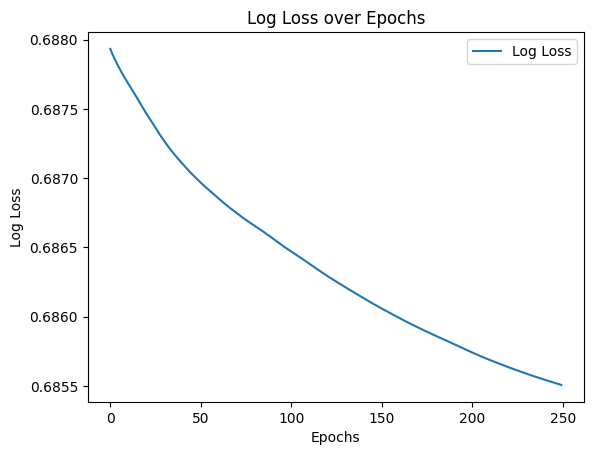

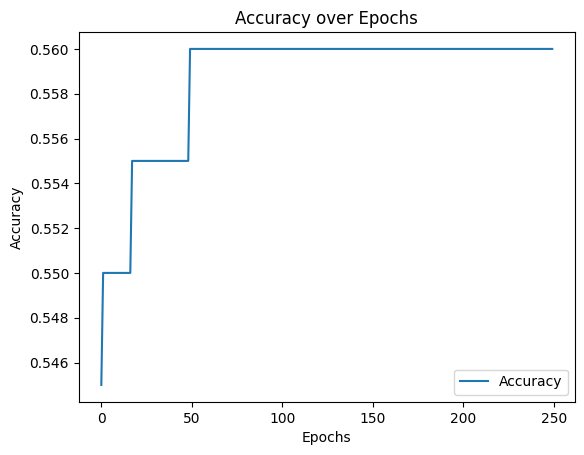

In [ ]:

def base():
    #load in and resize images ( 1 of each, use the ending tags to grab all)
    testSet = []
    trainSet = []
    testLabels = []
    trainLabels = []

    testFakeImg, testFakeLabels = loadImages(fpath, 'test', 0, testFalse)
    testRealImg, testRealLabels = loadImages(fpath, 'test', 1, testTrue)

    trainFakeImg, trainFakeLabels = loadImages(fpath, 'train', 0,trainFalse)
    trainRealImg, trainRealLabels = loadImages(fpath, 'train', 1, trainTrue)

    testSet.extend(testFakeImg)
    testSet.extend(testRealImg)
    testLabels.extend(testFakeLabels)
    testLabels.extend(testRealLabels)

    trainSet.extend(trainFakeImg)
    trainSet.extend(trainRealImg)
    trainLabels.extend(trainFakeLabels)
    trainLabels.extend(trainRealLabels)

    testLabels = np.array(testLabels).reshape(-1,1)
    trainLabels = np.array(trainLabels).reshape(-1,1)

    #create index of length of images for test and train
    #then shuffle, pass shuffled indices into arrays
    testSet = np.array(testSet)
    trainSet = np.array(trainSet)
    testIndicies = np.arange(testSet.shape[0])
    trainIndicies = np.arange(trainSet.shape[0])

    testShuffle = np.random.permutation(testIndicies)
    testSet = testSet[testShuffle]
    testLabels = testLabels[testShuffle]


    # First convolution layer (kernel size: 5x5)
    hConv = H - kSize + 1
    wConv = W - kSize + 1

    # First MaxPool layer (size: 2, stride: 2)
    hPool = ((hConv - mpSize) // mpStride) + 1
    wPool = ((wConv - mpSize) // mpStride) + 1

    # Flattening layer
    flatSize = hPool * wPool



    L1 = ConvolutionalLayer(kSize) # for kernel size NxN output size: ((H - N+2P)/S) + 1
    L2 = MaxPoolLayer(mpSize,mpStride) #output size, stride M and size DxD: ((H-D)/M)+1
    L3 = FlatteningLayer() #HxW
    L4 = FullyConnectedLayer(flatSize,1) # 1 FC, 1 sigmoid
    L5 = LogisticSigmoidLayer()
    L6 = LogLoss()
    layers = [L1,L2,L3,L4,L5,L6]
    loss = []
    accuracy = []

#train
    tic = time.perf_counter()
    print("Begin Training")
    for epoch in range(epochs):
      if (epoch%100 == 0) and (epoch != 0):
          toc = time.perf_counter()
          print("Last 100 Epochs: ",(toc-tic))
          tic = time.perf_counter()
      #shuffle each run to encourage learning
      trainShuffle = np.random.permutation(trainIndicies)
      trainSet = trainSet[trainShuffle]
      trainLabels = trainLabels[trainShuffle]
      X = trainSet.copy()
      #forward passes
      logloss = 0
      for layer in layers[:-1]:
          X = layer.forward(X)


      logloss = layers[-1].eval(trainLabels,X)

      loss.append(logloss)


      acc = np.mean((X >= 0.5).astype(int) == trainLabels)
      accuracy.append(acc)

      if (epoch%10 == 0) and (epoch != 0):
          print("Current epoch: ", epoch)
          print("Trues: ", np.sum((X >= 0.5)))
          print("Falses: ", np.sum((X < 0.5)))

          print("last acc: ",acc)


      #print(loss,acc)
      #backwards!
      #from slide: backwards gradients and update FC weights using training set
      grad = layers[-1].gradient(trainLabels,X)
      for i in range(len(layers)-2,0,-1):

          newgrad = layers[i].backward2(grad)

          if (isinstance(layers[i],FullyConnectedLayer)):
                  layers[i].updateWeights(grad,FCLearn)



          grad= newgrad
      layers[0].updateKernels(grad,KLearn)



    print("Ending Train Accuracy: ",   accuracy[-1])
    print("Ending Train Loss: ",loss[-1])

  #run on test:

    X = testSet.copy()
    #forward passes
    logloss = 0
    for layer in layers[:-1]:
        X = layer.forward(X)


    logloss = layers[-1].eval(testLabels,X)


    acc = np.sum((X >= 0.5) == testLabels) / len(testLabels)
    #accuracy.append(acc)


    #print(loss,acc)
    print("Ending Test Accuracy: ",   acc)
    print("Ending Test Loss: ",logloss)


    plt.figure()
    plt.plot(range(epochs), loss, label="Log Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Log Loss")
    plt.title("Log Loss over Epochs")
    plt.legend()
    plt.show()

    # Plot accuracy over epochs
    plt.figure()
    plt.plot(range(epochs), accuracy, label="Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()



base()

#CNN WITH MULTIPLE KERNELS

##Framework

In [ ]:
import numpy as np
import math
from scipy import signal
from abc import ABC, abstractmethod
import random
import sys
import os
from PIL import Image
import matplotlib.pyplot as plt
import time

########## BASE CLASS ###########
class Layer(ABC):
    def __init__(self):
        self.__prevIn = []
        self.__prevOut = []

    def setPrevIn(self, dataIn):
        self.__prevIn = dataIn

    def setPrevOut(self, out):
        self.__prevOut = out

    def getPrevIn(self):
        return self.__prevIn

    def getPrevOut(self):
        return self.__prevOut

    def backward(self, gradIn):
        sg = self.gradient()
        if sg.ndim == 3:
            gradOut = np.zeros((gradIn.shape[0], sg.shape[2]))
            for i in range(gradIn.shape[0]):
                gradOut[i] = np.atleast_2d(gradIn[i]) @ np.atleast_2d(sg[i])
        else:
            gradOut = np.atleast_2d(gradIn) @ sg
        return gradOut

    @abstractmethod
    def forward(self, dataIn):
        pass

    @abstractmethod
    def gradient(self):
        pass


########## CONVOLUTIONAL LAYER WITH MULTIPLE KERNELS ###########
class ConvolutionalLayer(Layer):
    def __init__(self, kernel_size, num_kernels):
        super().__init__()
        self.kernel_size = kernel_size
        self.num_kernels = num_kernels
        self.kernels = np.random.randn(num_kernels, kernel_size, kernel_size) * 0.1  # Small random values

    def setKernels(self, K):
        self.kernels = K

    def getKernels(self):
        return self.kernels

    @staticmethod
    def crossCorrelate2D(K, X):
        """Computes the cross-correlation of kernel K with input X."""
        m = K.shape[0]
        H, W = X.shape
        outH, outW = H - m + 1, W - m + 1
        result = np.zeros((outH, outW), dtype=float)

        for i in range(outH):
            for j in range(outW):
                result[i, j] = np.sum(X[i : i + m, j : j + m] * K)

        return result

    def forward(self, dataIn):
        """Applies multiple kernels to the input."""
        self.setPrevIn(dataIn)
        N, H, W = dataIn.shape
        m = self.kernel_size
        outH, outW = H - m + 1, W - m + 1

        output = np.zeros((N, self.num_kernels, outH, outW), dtype=float)
        for n in range(N):
            for k in range(self.num_kernels):
                output[n, k] = ConvolutionalLayer.crossCorrelate2D(self.kernels[k], dataIn[n])

        self.setPrevOut(output)
        return output

    def updateKernels(self, gradIn, eta):
        """Updates each kernel using the gradient."""
        N, K, outH, outW = gradIn.shape
        dK = np.zeros_like(self.kernels)

        for n in range(N):
            for k in range(self.num_kernels):
                for i in range(outH):
                    for j in range(outW):
                        patch = self.getPrevIn()[n, i : i + self.kernel_size, j : j + self.kernel_size]
                        dK[k] += patch * gradIn[n, k, i, j]

        self.kernels -= eta * dK

    def gradient(self):
      return np.ones_like(self.kernels)  # Placeholder; implement real computation



########## FLATTENING LAYER ###########
class FlatteningLayer(Layer):
    def forward(self, dataIn):
        self.setPrevIn(dataIn)
        N = dataIn.shape[0]
        out = dataIn.reshape(N, -1)  # Flattening across all dimensions
        self.setPrevOut(out)
        return out

    def backward(self, gradIn):
        return gradIn.reshape(self.getPrevIn().shape)

    def backward2(self, gradIn):
        return gradIn.reshape(self.getPrevIn().shape)

    def gradient(self):
      return np.ones_like(self.getPrevOut())  # Ensure it's not None



########## FULLY CONNECTED LAYER ###########
class FullyConnectedLayer(Layer):
    def __init__(self, sizeIn, sizeOut):
        super().__init__()
        #trying Xavier initialization to see if it leads anywhere
        #self.W = np.random.uniform(-1e-4, 1e-4, (sizeIn, sizeOut))
        #self.b = np.random.uniform(-1e-4, 1e-4, (1, sizeOut))

        #Xaiver
        a =  -(6/(sizeIn+sizeOut))**(1/2)
        b = (6/(sizeIn+sizeOut))**(1/2)
        self.W = np.random.uniform(a, b, (sizeIn, sizeOut))
        self.B = np.random.uniform(a, b, (1, sizeOut))

    def getWeights(self):
        return self.W

    def setWeights(self, W):
        self.W = W

    def getBiases(self):
        return self.B

    def setBiases(self, b):
        self.B = b

    def forward(self, dataIn):

        self.setPrevIn(dataIn)
        result = np.dot(dataIn, self.W) + self.B
        self.setPrevOut(result)
        return result

    def gradient(self):
        return np.tile(self.W.T, (self.getPrevIn().shape[0], 1, 1))

    def backward(self, gradIn):
        gradOut = super().backward(gradIn)
        dW = np.dot(self.getPrevIn().T, gradIn)
        db = np.sum(gradIn, axis=0, keepdims=True)
        self.dW = dW
        self.db = db
        return gradOut

    def backward2(self, gradIn):
        return np.dot(gradIn, self.W.T)

    def updateWeights(self,gradIn, eta):

        dJdb = np.sum(gradIn, axis = 0)/gradIn.shape[0]
        dJdW = (self.getPrevIn().T @ gradIn)/gradIn.shape[0]

        self.W -= eta*dJdW
        self.B -= eta*dJdb


########## MAX POOLING LAYER ###########
class MaxPoolLayer(Layer):
    def __init__(self, pool_size, stride):
        super().__init__()
        self.pool_size = pool_size
        self.stride = stride

    def forward(self, dataIn):
        self.setPrevIn(dataIn)
        N, K, H, W = dataIn.shape  # dataIn has shape (N, K, H, W)
        ps, st = self.pool_size, self.stride
        outH, outW = (H - ps) // st + 1, (W - ps) // st + 1

        output = np.zeros((N, K, outH, outW), dtype=float)
        self.max_indices = np.zeros((N, K, outH, outW, 2), dtype=int)

        # Apply max pooling for each kernel (feature map)
        for n in range(N):
            for k in range(K):  # Loop over each channel (kernel's output feature map)
                for i in range(outH):
                    for j in range(outW):
                        r_start, c_start = i * st, j * st
                        region = dataIn[n, k, r_start:r_start+ps, c_start:c_start+ps]
                        output[n, k, i, j] = np.max(region)
                        idx = np.unravel_index(np.argmax(region), region.shape)
                        self.max_indices[n, k, i, j] = idx

        self.setPrevOut(output)
        return output

    def gradient(self):
        pass

    def backward(self, gradIn):
        N, K, H, W = self.getPrevIn().shape  # dataIn has shape (N, K, H, W)

        # Initialize gradient output (same shape as the input to the max pooling layer)
        gradOut = np.zeros((N, K, H, W), dtype=float)

        # Loop through the batch and channels (feature maps from different kernels)
        for n in range(N):  # Loop over the batch
            for k in range(K):  # Loop over the channels (feature maps from different kernels)
                for i in range(gradIn.shape[2]):  # Loop over the height of the output (gradIn)
                    for j in range(gradIn.shape[3]):  # Loop over the width of the output (gradIn)
                        # Get the index of the maximum value from the forward pass
                        max_idx = self.max_indices[n, k, i, j]

                        # Convert the flattened index back to 2D (row, column)
                        max_i, max_j = np.unravel_index(max_idx, (self.pool_size, self.pool_size))

                        # Calculate the start position of the pooling region
                        start_i = i * self.stride
                        start_j = j * self.stride

                        # Calculate the global position (row, column) in the original input image
                        global_i = start_i + max_i
                        global_j = start_j + max_j

                        # Update the gradient at the global position for the current feature map
                        gradOut[n, k, global_i, global_j] += gradIn[n, k, i, j]

        return gradOut


    def backward2(self, gradIn):
        N, K, H, W = self.getPrevIn().shape  # dataIn has shape (N, K, H, W)

        # Initialize gradient output (same shape as the input to the max pooling layer)
        gradOut = np.zeros((N, K, H, W), dtype=float)

        # Loop through the batch and channels (feature maps from different kernels)
        for n in range(N):  # Loop over the batch
            for k in range(K):  # Loop over the channels (feature maps from different kernels)
                for i in range(gradIn.shape[2]):  # Loop over the height of the output (gradIn)
                    for j in range(gradIn.shape[3]):  # Loop over the width of the output (gradIn)
                        # Get the index of the maximum value from the forward pass
                        max_idx = self.max_indices[n, k, i, j]

                        # Convert the flattened index back to 2D (row, column)
                        max_i, max_j = np.unravel_index(max_idx, (self.pool_size, self.pool_size))

                        # Calculate the start position of the pooling region
                        start_i = i * self.stride
                        start_j = j * self.stride

                        # Calculate the global position (row, column) in the original input image
                        global_i = start_i + max_i
                        global_j = start_j + max_j

                        # Update the gradient at the global position for the current feature map
                        gradOut[n, k, global_i, global_j] += gradIn[n, k, i, j]

        return gradOut



########## LOG LOSS ###########
class LogLoss:
    def eval(self, Y, Yhat):
        eps = 1e-7
        Yhat = np.clip(Yhat, eps, 1 - eps)
        return -np.mean(Y * np.log(Yhat) + (1 - Y) * np.log(1 - Yhat))

    def gradient(self, Y, Yhat):
        eps = 1e-7
        Yhat = np.clip(Yhat, eps, 1 - eps)
        return (1 - Y) / (1 - Yhat) - Y / Yhat


########## LOGISTIC SIGMOID LAYER ###########
class LogisticSigmoidLayer(Layer):
    def forward(self, dataIn):
        self.setPrevIn(dataIn)
        dataIn = np.clip(dataIn, -500, 500)
        result = 1 / (1 + np.exp(-dataIn))
        self.setPrevOut(result)
        return result

    def backward(self, gradIn):
        sigmoid = self.getPrevOut()
        return gradIn * (sigmoid * (1 - sigmoid))

    def gradient(self):
        pass

    def gradient2(self):
        G = self.getPrevOut() * (1 - self.getPrevOut())
        return G

    def backward2(self,gradIn):
        gradOut = gradIn*self.gradient2()
        return gradOut




##Run Model

Begin Training
Epoch 10: Accuracy 0.5450, Loss 0.6865
Epoch 20: Accuracy 0.5450, Loss 0.6847
Epoch 30: Accuracy 0.5550, Loss 0.6841
Epoch 40: Accuracy 0.5600, Loss 0.6838
Epoch 50: Accuracy 0.5600, Loss 0.6835
Epoch 60: Accuracy 0.5600, Loss 0.6831
Epoch 70: Accuracy 0.5600, Loss 0.6827
Epoch 80: Accuracy 0.5600, Loss 0.6823
Epoch 90: Accuracy 0.5600, Loss 0.6821
Last 100 Epochs: 3408.81 seconds
Epoch 100: Accuracy 0.5600, Loss 0.6819
Epoch 110: Accuracy 0.5600, Loss 0.6818
Epoch 120: Accuracy 0.5600, Loss 0.6816
Epoch 130: Accuracy 0.5600, Loss 0.6814
Epoch 140: Accuracy 0.5600, Loss 0.6813
Epoch 150: Accuracy 0.5600, Loss 0.6813
Epoch 160: Accuracy 0.5600, Loss 0.6811
Epoch 170: Accuracy 0.5600, Loss 0.6809
Epoch 180: Accuracy 0.5600, Loss 0.6809
Epoch 190: Accuracy 0.5600, Loss 0.6807
Last 100 Epochs: 3408.04 seconds
Epoch 200: Accuracy 0.5600, Loss 0.6804
Epoch 210: Accuracy 0.5600, Loss 0.6800
Epoch 220: Accuracy 0.5600, Loss 0.6796
Epoch 230: Accuracy 0.5600, Loss 0.6793
Epoch 24

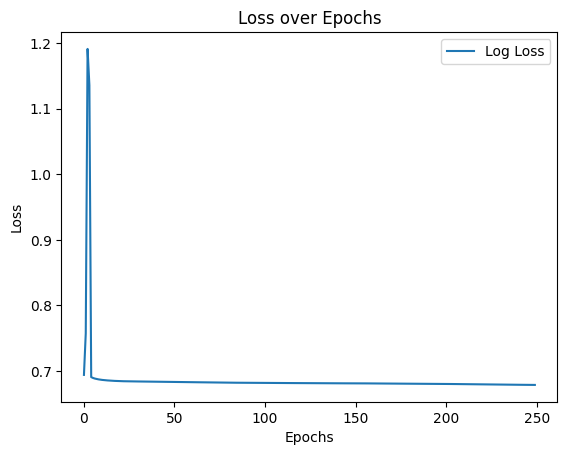

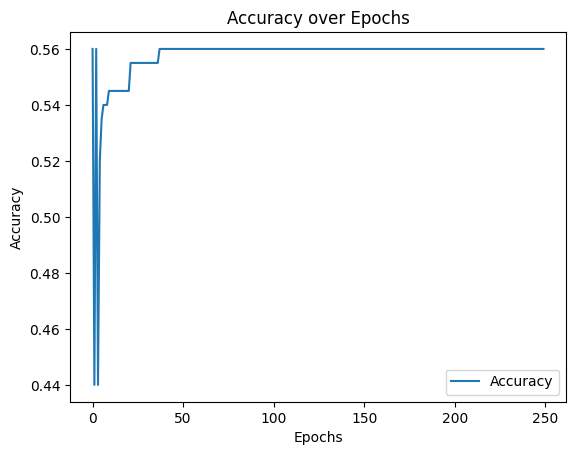

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt

def train_cnn():
    #kernel parameters

    # Load and resize images
    testSet, trainSet, testLabels, trainLabels = [], [], [], []

    testFakeImg, testFakeLabels = loadImages(fpath, 'test', 0, testFalse)
    testRealImg, testRealLabels = loadImages(fpath, 'test', 1, testTrue)
    trainFakeImg, trainFakeLabels = loadImages(fpath, 'train', 0, trainFalse)
    trainRealImg, trainRealLabels = loadImages(fpath, 'train', 1, trainTrue)

    testSet.extend(testFakeImg + testRealImg)
    testLabels.extend(testFakeLabels + testRealLabels)
    trainSet.extend(trainFakeImg + trainRealImg)
    trainLabels.extend(trainFakeLabels + trainRealLabels)

    testLabels = np.array(testLabels).reshape(-1, 1)
    trainLabels = np.array(trainLabels).reshape(-1, 1)

    # Shuffle data
    testSet, trainSet = np.array(testSet), np.array(trainSet)
    testShuffle, trainShuffle = np.random.permutation(len(testSet)), np.random.permutation(len(trainSet))
    testSet, testLabels = testSet[testShuffle], testLabels[testShuffle]
    trainSet, trainLabels = trainSet[trainShuffle], trainLabels[trainShuffle]

    #Calc Dimensions

    # First convolution layer (kernel size: 5x5)
    hConv = H - kSize + 1
    wConv = W - kSize + 1

    # First MaxPool layer (size: 2, stride: 2)
    hPool = ((hConv - mpSize) // mpStride) + 1
    wPool = ((wConv - mpSize) // mpStride) + 1

    # Flattening layer
    flatSize = hPool * wPool * numKernels



    # Initialize layers
    L1 = ConvolutionalLayer(kSize, numKernels)
    L2 = MaxPoolLayer(mpSize, mpStride)
    L3 = FlatteningLayer()
    L4 = FullyConnectedLayer(flatSize, weightOut)
    L5 = LogisticSigmoidLayer()
    L6 = LogLoss()
    layers = [L1, L2, L3, L4, L5, L6]

    loss, accuracy = [], []
    tic = time.perf_counter()

    print("Begin Training")
    for epoch in range(epochs):
        if epoch % 100 == 0 and epoch != 0:
            toc = time.perf_counter()
            print(f"Last 100 Epochs: {toc - tic:.2f} seconds")
            tic = time.perf_counter()

        trainShuffle = np.random.permutation(len(trainSet))
        trainSet, trainLabels = trainSet[trainShuffle], trainLabels[trainShuffle]
        X = trainSet.copy()

        # Forward pass
        for layer in layers[:-1]:
            X = layer.forward(X)
        logloss = layers[-1].eval(trainLabels, X)
        loss.append(logloss)

        acc = np.mean((X >= 0.5).astype(int) == trainLabels)
        accuracy.append(acc)

        if epoch % 10 == 0 and epoch != 0:
            print(f"Epoch {epoch}: Accuracy {acc:.4f}, Loss {logloss:.4f}")

        # Backward pass
        grad = layers[-1].gradient(trainLabels, X)
        for i in range(len(layers) - 2, 0, -1):
            newgrad = layers[i].backward2(grad)
            if isinstance(layers[i], FullyConnectedLayer):
                layers[i].updateWeights(grad, FCLearn)
            grad = newgrad
        layers[0].updateKernels(grad, KLearn)

    print(f"Final Training Accuracy: {accuracy[-1]:.4f}")
    print(f"Final Training Loss: {loss[-1]:.4f}")

    # Evaluation on test set
    X = testSet.copy()
    for layer in layers[:-1]:
        X = layer.forward(X)
    logloss = layers[-1].eval(testLabels, X)
    test_acc = np.mean((X >= 0.5) == testLabels)

    print(f"Final Test Accuracy: {test_acc:.4f}")
    print(f"Final Test Loss: {logloss:.4f}")

    # Plot loss and accuracy
    plt.figure()
    plt.plot(range(epochs), loss, label="Log Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(range(epochs), accuracy, label="Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    train_cnn()


#CNN WITH RGB CHANNELS

##Framework

In [7]:
import numpy as np
import math
from scipy import signal
from abc import ABC, abstractmethod
import random
import sys
import os
from PIL import Image
import matplotlib.pyplot as plt
import time

########## BASE CLASS ###########
class Layer(ABC):
    def __init__(self):
        self.__prevIn = []
        self.__prevOut = []

    def setPrevIn(self, dataIn):
        self.__prevIn = dataIn

    def setPrevOut(self, out):
        self.__prevOut = out

    def getPrevIn(self):
        return self.__prevIn

    def getPrevOut(self):
        return self.__prevOut

    def backward(self, gradIn):
        sg = self.gradient()
        if sg.ndim == 3:
            gradOut = np.zeros((gradIn.shape[0], sg.shape[2]))
            for i in range(gradIn.shape[0]):
                gradOut[i] = np.atleast_2d(gradIn[i]) @ np.atleast_2d(sg[i])
        else:
            gradOut = np.atleast_2d(gradIn) @ sg
        return gradOut

    @abstractmethod
    def forward(self, dataIn):
        pass

    @abstractmethod
    def gradient(self):
        pass


########## CONVOLUTIONAL LAYER WITH MULTIPLE KERNELS ###########
class ConvolutionalLayer(Layer):
    def __init__(self, kernel_size, num_kernels):
        super().__init__()
        self.kernel_size = kernel_size
        self.num_kernels = num_kernels
        # Kernels should have 3 channels (R, G, B)
        self.kernels = np.random.randn(num_kernels, kernel_size, kernel_size, 3) * 0.1  # Small random values

    def setKernels(self, K):
        self.kernels = K

    def getKernels(self):
        return self.kernels

    @staticmethod
    def crossCorrelate2D(K, X):
        """Computes cross-correlation of 3D kernel K with 3D input X."""
        m = K.shape[0]  # Kernel size
        H, W, C = X.shape  # Input dimensions (Height, Width, 3 channels)

        outH, outW = H - m + 1, W - m + 1
        result = np.zeros((outH, outW), dtype=float)

        for i in range(outH):
            for j in range(outW):
                # Apply kernel to all 3 channels and sum the result
                result[i, j] = np.sum(X[i : i + m, j : j + m, :] * K)

        return result

    def forward(self, dataIn):
        """Applies multiple kernels to the input RGB images."""
        self.setPrevIn(dataIn)
        N, H, W, C = dataIn.shape  # Ensure input has 4D shape (batch, height, width, channels)
        m = self.kernel_size
        outH, outW = H - m + 1, W - m + 1

        output = np.zeros((N, self.num_kernels, outH, outW), dtype=float)
        for n in range(N):
            for k in range(self.num_kernels):
                output[n, k] = ConvolutionalLayer.crossCorrelate2D(self.kernels[k], dataIn[n])

        self.setPrevOut(output)
        return output

    def updateKernels(self, gradIn, eta):
        """Updates each kernel using the gradient."""
        N, K, outH, outW = gradIn.shape
        dK = np.zeros_like(self.kernels)

        for n in range(N):
            for k in range(self.num_kernels):
                for i in range(outH):
                    for j in range(outW):
                        patch = self.getPrevIn()[n, i : i + self.kernel_size, j : j + self.kernel_size]
                        dK[k] += patch * gradIn[n, k, i, j]

        self.kernels -= eta * dK

    def gradient(self):
      return np.ones_like(self.kernels)  # Placeholder; implement real computation



########## FLATTENING LAYER ###########
class FlatteningLayer(Layer):
    def forward(self, dataIn):
        self.setPrevIn(dataIn)
        N = dataIn.shape[0]
        out = dataIn.reshape(N, -1)  # Flattening across all dimensions
        self.setPrevOut(out)
        return out

    def backward(self, gradIn):
        return gradIn.reshape(self.getPrevIn().shape)

    def gradient(self):
      return np.ones_like(self.getPrevOut())  # Ensure it's not None

    def backward2(self, gradIn):
        return gradIn.reshape(self.getPrevIn().shape)



########## FULLY CONNECTED LAYER ###########
class FullyConnectedLayer(Layer):
    def __init__(self, sizeIn, sizeOut):
        super().__init__()
        #trying Xavier initialization to see if it leads anywhere
        #self.W = np.random.uniform(-1e-4, 1e-4, (sizeIn, sizeOut))
        #self.b = np.random.uniform(-1e-4, 1e-4, (1, sizeOut))

        #Xaiver
        a =  -(6/(sizeIn+sizeOut))**(1/2)
        b = (6/(sizeIn+sizeOut))**(1/2)
        self.W = np.random.uniform(a, b, (sizeIn, sizeOut))
        self.B = np.random.uniform(a, b, (1, sizeOut))
    def getWeights(self):
        return self.W

    def setWeights(self, W):
        self.W = W

    def getBiases(self):
        return self.B

    def setBiases(self, b):
        self.B = b

    def forward(self, dataIn):

        self.setPrevIn(dataIn)
        result = np.dot(dataIn, self.W) + self.B
        self.setPrevOut(result)
        return result

    def gradient(self):
        return np.tile(self.W.T, (self.getPrevIn().shape[0], 1, 1))

    def backward(self, gradIn):
        gradOut = super().backward(gradIn)
        dW = np.dot(self.getPrevIn().T, gradIn)
        db = np.sum(gradIn, axis=0, keepdims=True)
        self.dW = dW
        self.db = db
        return gradOut

    def backward2(self, gradIn):
        return np.dot(gradIn, self.W.T)

    def updateWeights(self,gradIn, eta):

        dJdb = np.sum(gradIn, axis = 0)/gradIn.shape[0]
        dJdW = (self.getPrevIn().T @ gradIn)/gradIn.shape[0]

        self.W -= eta*dJdW
        self.B -= eta*dJdb


########## MAX POOLING LAYER ###########
class MaxPoolLayer(Layer):
    def __init__(self, pool_size, stride):
        super().__init__()
        self.pool_size = pool_size
        self.stride = stride

    def forward(self, dataIn):
        self.setPrevIn(dataIn)
        N, K, H, W = dataIn.shape
        ps, st = self.pool_size, self.stride
        outH, outW = (H - ps) // st + 1, (W - ps) // st + 1

        output = np.zeros((N, K, outH, outW), dtype=float)
        self.max_indices = np.zeros((N, K, outH, outW, 2), dtype=int)

        for n in range(N):
            for k in range(K):
                for i in range(outH):
                    for j in range(outW):
                        r_start, c_start = i * st, j * st
                        region = dataIn[n, k, r_start:r_start+ps, c_start:c_start+ps]
                        output[n, k, i, j] = np.max(region)
                        idx = np.unravel_index(np.argmax(region), region.shape)
                        self.max_indices[n, k, i, j] = idx

        self.setPrevOut(output)
        return output

    def gradient(self):
        pass

    def backward(self, gradIn):
      N, K, H, W = self.getPrevIn().shape  # Account for RGB (K channels)

      # Initialize gradient output (same shape as the input to the max pooling layer)
      gradOut = np.zeros((N, K, H, W), dtype=float)

      for n in range(N):  # Loop over the batch
          for k in range(K):  # Loop over the channels (R, G, B)
              for i in range(gradIn.shape[1]):  # Loop over the height of the output (gradIn)
                  for j in range(gradIn.shape[2]):  # Loop over the width of the output (gradIn)
                      # Get the index of the maximum value from the forward pass
                      max_idx = self.max_indices[n, k, i, j]

                      # Convert the flattened index back to 2D (row, column)
                      max_i, max_j = np.unravel_index(max_idx, (self.pool_size, self.pool_size))

                      # Calculate the start position of the pooling region
                      start_i = i * self.stride
                      start_j = j * self.stride

                      # Calculate the global position (row, column) in the original input image
                      global_i = start_i + max_i
                      global_j = start_j + max_j

                      # Update the gradient at the global position for the current channel
                      gradOut[n, k, global_i, global_j] += gradIn[n, k, i, j]

      return gradOut


    def backward2(self, gradIn):
      N, K, H, W = self.getPrevIn().shape  # Account for RGB (K channels)

      # Initialize gradient output (same shape as the input to the max pooling layer)
      gradOut = np.zeros((N, K, H, W), dtype=float)

      for n in range(N):  # Loop over the batch
          for k in range(K):  # Loop over the channels (R, G, B)
              for i in range(gradIn.shape[1]):  # Loop over the height of the output (gradIn)
                  for j in range(gradIn.shape[2]):  # Loop over the width of the output (gradIn)
                      # Get the index of the maximum value from the forward pass
                      max_idx = self.max_indices[n, k, i, j]

                      # Convert the flattened index back to 2D (row, column)
                      max_i, max_j = np.unravel_index(max_idx, (self.pool_size, self.pool_size))

                      # Calculate the start position of the pooling region
                      start_i = i * self.stride
                      start_j = j * self.stride

                      # Calculate the global position (row, column) in the original input image
                      global_i = start_i + max_i
                      global_j = start_j + max_j

                      # Update the gradient at the global position for the current channel
                      gradOut[n, k, global_i, global_j] += gradIn[n, k, i, j]

      return gradOut



########## LOG LOSS ###########
class LogLoss:
    def eval(self, Y, Yhat):
        eps = 1e-7
        Yhat = np.clip(Yhat, eps, 1 - eps)
        return -np.mean(Y * np.log(Yhat) + (1 - Y) * np.log(1 - Yhat))

    def gradient(self, Y, Yhat):
        eps = 1e-7
        Yhat = np.clip(Yhat, eps, 1 - eps)
        return (1 - Y) / (1 - Yhat) - Y / Yhat


########## LOGISTIC SIGMOID LAYER ###########
class LogisticSigmoidLayer(Layer):
    def forward(self, dataIn):
        self.setPrevIn(dataIn)
        result = 1 / (1 + np.exp(-np.clip(dataIn, -500, 500))) #trying to avoid overflow, can toggle the clip
        self.setPrevOut(result)
        return result

    def backward(self, gradIn):
        sigmoid = self.getPrevOut()
        return gradIn * (sigmoid * (1 - sigmoid))

    def gradient(self):
      pass

    def gradient2(self):
        G = self.getPrevOut() * (1 - self.getPrevOut())
        return G

    def backward2(self,gradIn):
        gradOut = gradIn*self.gradient2()
        return gradOut




##Load Color Images

In [8]:
def loadImages(fpath, folder, label, max_images):
    """
    Loads RGB images from a given directory and assigns them a label.
    """
    images = []
    labels = []

    folder_path = os.path.join(fpath, folder)
    for subfolder in ['Fake', 'Real']:
        spath = os.path.join(folder_path, subfolder)
        for file in os.listdir(spath):
            img_path = os.path.join(spath, file)
            image = Image.open(img_path).convert("RGB")
            image = image.resize((H, W))
            image_array = np.array(image, dtype=np.float32) / 255.0

            images.append(image_array)
            labels.append(label)

            # Limit the dataset size
            if len(images) >= max_images:
                return images, labels

    return images, labels


##Run Model

In [9]:
def train_cnn_rgb():
    # Load and preprocess images
    testSet = []
    trainSet = []
    testLabels = []
    trainLabels = []

    testFakeImg, testFakeLabels = loadImages(fpath, 'test', 0, testFalse)
    testRealImg, testRealLabels = loadImages(fpath, 'test', 1, testTrue)

    trainFakeImg, trainFakeLabels = loadImages(fpath, 'train', 0, trainFalse)
    trainRealImg, trainRealLabels = loadImages(fpath, 'train', 1, trainTrue)

    testSet.extend(testFakeImg)
    testSet.extend(testRealImg)
    testLabels.extend(testFakeLabels)
    testLabels.extend(testRealLabels)

    trainSet.extend(trainFakeImg)
    trainSet.extend(trainRealImg)
    trainLabels.extend(trainFakeLabels)
    trainLabels.extend(trainRealLabels)

    testLabels = np.array(testLabels).reshape(-1,1)
    trainLabels = np.array(trainLabels).reshape(-1,1)

    # Convert to NumPy arrays
    testSet = np.array(testSet)  # Should be (N, H, W, 3)
    trainSet = np.array(trainSet)

    # Shuffle training data
    trainIndicies = np.arange(trainSet.shape[0])
    np.random.shuffle(trainIndicies)
    trainSet = trainSet[trainIndicies]
    trainLabels = trainLabels[trainIndicies]


    # First convolution layer (kernel size: 5x5)
    hConv = H - kSize + 1
    wConv = W - kSize + 1

    # First MaxPool layer (size: 2, stride: 2)
    hPool = ((hConv - mpSize) // mpStride) + 1
    wPool = ((wConv - mpSize) // mpStride) + 1

    # Flattening layer
    flatSize = hPool * wPool * 3

    # Initialize layers
    L1 = ConvolutionalLayer(kSize, 3)
    L2 = MaxPoolLayer(mpSize, mpStride)
    L3 = FlatteningLayer()
    L4 = FullyConnectedLayer(flatSize, weightOut)
    L5 = LogisticSigmoidLayer()
    L6 = LogLoss()

    layers = [L1, L2, L3, L4, L5, L6]

    loss, accuracy = [], []
    tic = time.perf_counter()

    print("Begin Training")
    for epoch in range(100):
        if epoch % 100 == 0 and epoch != 0:
            toc = time.perf_counter()
            print(f"Last 100 Epochs: {toc - tic:.2f} seconds")
            tic = time.perf_counter()

        trainShuffle = np.random.permutation(len(trainSet))
        trainSet, trainLabels = trainSet[trainShuffle], trainLabels[trainShuffle]
        X = trainSet.copy()

        # Forward pass
        for layer in layers[:-1]:
            X = layer.forward(X)
        logloss = layers[-1].eval(trainLabels, X)
        loss.append(logloss)

        acc = np.mean((X >= 0.5).astype(int) == trainLabels)
        accuracy.append(acc)

        if epoch % 10 == 0 and epoch != 0:
            print(f"Epoch {epoch}: Accuracy {acc:.4f}, Loss {logloss:.4f}")

        # Backward pass
        grad = layers[-1].gradient(trainLabels, X)
        for i in range(len(layers) - 2, 0, -1):
            newgrad = layers[i].backward2(grad)
            if isinstance(layers[i], FullyConnectedLayer):
                layers[i].updateWeights(grad, FCLearn)
            grad = newgrad
        layers[0].updateKernels(grad, KLearn)

    print(f"Final Training Accuracy: {accuracy[-1]:.4f}")
    print(f"Final Training Loss: {loss[-1]:.4f}")

    # Evaluation on test set
    X = testSet.copy()
    for layer in layers[:-1]:
        X = layer.forward(X)
    logloss = layers[-1].eval(testLabels, X)
    test_acc = np.mean((X >= 0.5) == testLabels)

    print(f"Final Test Accuracy: {test_acc:.4f}")
    print(f"Final Test Loss: {logloss:.4f}")

    # Plot loss and accuracy
    plt.figure()
    plt.plot(range(epochs), loss, label="Log Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(range(epochs), accuracy, label="Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()


if __name__ == "__main__":
    train_cnn_rgb()

Begin Training
Epoch 10: Accuracy 0.5550, Loss 0.6893
Epoch 20: Accuracy 0.5450, Loss 0.6893
Epoch 30: Accuracy 0.5450, Loss 0.6895
Epoch 40: Accuracy 0.5450, Loss 0.6900
Epoch 50: Accuracy 0.5450, Loss 0.6913
Epoch 60: Accuracy 0.5400, Loss 0.6934
Epoch 70: Accuracy 0.5400, Loss 0.6941
Epoch 80: Accuracy 0.5200, Loss 0.6953
Epoch 90: Accuracy 0.5400, Loss 0.6911


KeyboardInterrupt: 

#CNN WITH MULTIPLE CONVOLUTION LAYERS

##Framework



In [ ]:
import numpy as np
import math
from scipy import signal
from abc import ABC, abstractmethod
import random
import sys
import os
from PIL import Image
import matplotlib.pyplot as plt
import time

##########BASE CLASS###########
class Layer(ABC):
  def __init__(self):
    self.__prevIn = []
    self.__prevOut = []

  def setPrevIn(self,dataIn):
    self.__prevIn = dataIn

  def setPrevOut(self, out):
    self.__prevOut = out

  def getPrevIn(self):
    return self.__prevIn

  def getPrevOut(self):
    return self.__prevOut

  """
  def backward(self, gradIn):
    sg = self.gradient()
    gradOut = np.zeros((gradIn.shape[0],sg.shape[2]))

    for n in range(gradIn.shape[0]):
        gradOut[n] = np.atleast_2d(gradIn[n])@sg[n]
    return gradOut
  """
  def backward(self,gradIn):
    #from lecture slides:

    #sg = self.gradient()
    #gradOut = np.zeros((gradIn.shape[0],sg.shape[1]))
    #for i in range(gradIn.shape[0]):
    #  gradOut[i] = np.atleast_2d(gradIn[i])@np.atleast_2d(sg[i])
    #  return gradOut


    sg = self.gradient()

    if(sg.ndim == 3):  #tensor coming back
        gradOut = np.zeros((gradIn.shape[0],sg.shape[2]))
        for i in range(gradIn.shape[0]):
            gradOut[i] = np.atleast_2d(gradIn[i])@np.atleast_2d(sg[i])
    else:
        gradOut = np.atleast_2d(gradIn)@sg

    return gradOut

  @abstractmethod
  def forward(self,dataIn):
    pass

  @abstractmethod
  def gradient(self):
    pass

##########BASE CLASS###########
class Objective(ABC):
    def __init__(self):
        pass

    @abstractmethod
    def eval(Y,Yhat):
        pass

    @abstractmethod
    def gradient(Y,Yhat):
        pass


#\/\/\/\/CONVOLUTION\/\/\/\/
class ConvolutionalLayer(Layer):

    '''Constructor (init)- Your constructor should take in a single
    explicit parameter, the kernel size.
    We will assume the kernel is square, of an odd size,
    and that will have a single kernel '''

    def __init__(self, kernelSize):
        super().__init__()
        #is zeros right?
        #check for odd number size?
        a = -1e-2
        b = 1e-2
        self.kernel = np.random.uniform(a, b, (kernelSize, kernelSize))


    def setKernels(self,K):
        '''- This method should take a matrix (or tensor) as a parameter
        and set the weights of the kernel(s) to it. '''

        self.kernel = K

    def getKernels(self):

        return self.kernel

    @staticmethod
    def crossCorrelate2D(K,N):
        '''This static method should take two matrices as parameters,
        and return their cross-correlation. You do not need to support padding.'''
        N_height, N_width = N.shape
        K_height, K_width = K.shape

        result_height = N_height - K_height + 1
        result_width = N_width - K_width + 1

        result = np.zeros((result_height, result_width))

        for i in range(result_height):
            for j in range(result_width):
                submatrix = N[i: i+K_height, j: j+K_width]
                result[i, j] = np.sum(submatrix * K)


        return result


    def forward(self,X):
        '''This method should take a tensor of incoming data (N × H × W),
        set prevIn with it, compute the cross-correlation of
        each observations with the kernel,
        store this result with its parent class (prevOut)
        and return it (this output should also be a tensor). '''
        self.setPrevIn(X)
        N,H,W = X.shape
        outputs = []

        for i in range(N):

            result = ConvolutionalLayer.crossCorrelate2D(self.kernel,X[i])

            outputs.append(result)

        result = np.stack(outputs,axis=0)
        self.setPrevOut(result)
        return result


    def gradient(self):
        pass

    def backward2(self, backGrad):
        ''' Backward pass: Compute the gradient with respect to the inputs. '''

        # Get the previous input and kernel
        X = self.getPrevIn()  # (N, H, W)
        kernel = self.getKernels()  # (K_h, K_w)
        N, H, W = X.shape  # N = batch size, H = height, W = width of input
        K_h, K_w = kernel.shape  # Kernel height and width

        # Initialize the gradient for the input (gradIn) with the same shape as the input
        gradIn = np.zeros_like(X)

        # Loop through each sample in the batch
        for n in range(N):
            # Loop over every position in the input (sliding window for convolution)
            for i in range(H - K_h + 1):
                for j in range(W - K_w + 1):
                    # For each position, get the patch from the output gradient (backGrad)
                    grad_patch = backGrad[n, i, j]

                    # Get the region of the input that corresponds to this position
                    input_patch = X[n, i:i + K_h, j:j + K_w]

                    # Now we calculate the gradient with respect to the input by reversing the convolution operation
                    gradIn[n, i:i + K_h, j:j + K_w] += grad_patch * kernel  # element-wise multiplication

        return gradIn

    def updateKernels(self,backGrad,eta):
        X = self.getPrevIn()
        N, H, W = X.shape

        kernelGrad = np.zeros(self.kernel.shape,dtype='float64')


        for n in range(N):
            for i in range(H - self.kernel.shape[0] + 1):
                for j in range(W - self.kernel.shape[1] + 1):
                    input_patch = X[n, i:i + self.kernel.shape[0], j:j + self.kernel.shape[1]]

                    kernelGrad += input_patch * backGrad[n, i, j]


        self.kernel = self.kernel -  eta * kernelGrad

#\/\/\/\/Cross Entropy\/\/\/\/

class CrossEntropy(Objective):
    def eval(self,Y,Yhat):
        constant = 10**-7
        tmp = Y*np.log(Yhat+constant)
        return -np.mean(np.sum(tmp,axis=1))



    def gradient(self,Y,Yhat):
        constant = 10e-7
        return -(Y/(Yhat + constant))


#\/\/\/\/Flatten\/\/\/\/
class FlatteningLayer(Layer):
    def __init__(self):
        super().__init__()

    def forward(self, X):
        self.setPrevIn(X)

        N,H,W = X.shape
        flatten = X.reshape(N,-1,order="F")

        self.setPrevOut(flatten)
        return flatten

    def gradient(self):
        pass

    def backward(self,gradIn):
        #return original dimensions
        N,H,W = self.getPrevIn().shape

        gradOut = gradIn.reshape(N,H,W, order="F")

        return gradOut

    def backward2(self,gradIn):
        #return original dimensions
        #copy -- all other functions for Q2 have a backward 2 method, this makes it easier without messing with the test script
        N,H,W = self.getPrevIn().shape

        gradOut = gradIn.reshape(N,H,W, order="F")

        return gradOut


#\/\/\/\/FullyConnected\/\/\/\/
class FullyConnectedLayer(Layer):
     #Input : sizeIn , the number of features of data coming in
    # #Input : sizeOut , the number of features for the data coming out.
    # #Output: None

    def __init__(self, sizeIn, sizeOut,useBias=0):
        super().__init__()
        #useBias needed for test, unsure where it fits in this setup

        #initialize weight and bias
        #Xaiver (move to INput)
        a =  -(6/(sizeIn+sizeOut))**(1/2)
        b = (6/(sizeIn+sizeOut))**(1/2)
        self.W = np.random.uniform(a, b, (sizeIn, sizeOut))
        self.B = np.random.uniform(a, b, (1, sizeOut))

     #  #Input : None
    # #Output: The (sizeIn by sizeOut) weight matrix.
    def getWeights(self):
        return self.W

    # #Input : The (sizeIn by sizeOut) weight matrix.
    # #Output: None
    def setWeights(self, weights):
        self.W = weights


     # #Input : None
    # #Output: The (1 by sizeOut) bias vector
    def getBiases(self):
        return self.B

     # #Input : The (1 by sizeOut) bias vector
    # #Output: None
    def setBiases(self, biases):
        self.B = biases

     # #Input : dataIn , a (1 by D) data matrix
    # #Output: A (1 by K) data matrix
    def forward(self, dataIn):

        self.setPrevIn(dataIn)
        Y = np.dot(dataIn, self.W) + self.B
        self.setPrevOut(Y)
        return Y

    # #We’ ll worry about this later ...
    def gradient( self ):
        #deriv = wT
        return self.W.T

    def updateWeights(self,gradIn,eta):
        #from lecture slide
        #bias graidnet - average of sum of gradIn (avg hadmaradnd product of bias and identity)
        #weight - input transpose @ gradIn avged over gradient shape.
        #both updates of X = X-learningrate*gradient calc
        getW = self.getWeights()
        dJdb = np.sum(gradIn, axis=0)/gradIn.shape[0]
        dJdW = (self.getPrevIn().T @ gradIn)/gradIn.shape[0]


        self.W = self.W -  eta*dJdW
        self.B = self.B - eta*dJdb

    def backward2(self,gradIn):

        gradOut = np.dot(gradIn, self.gradient())
        return gradOut

#\/\/\/\/Input\/\/\/\/
class InputLayer(Layer):
    #Input : dataIn , an (N by D) matrix
    # #Output: None

    def __init__( self , dataIn,z_score=0 ):
        #take the mean and standard deviation of each column
        if z_score != 0:
            self.meanX = np.mean(dataIn,axis=0)
            self.stdX = np.std(dataIn,axis=0,ddof=1)
            self.stdX[self.stdX == 0] = 1
        else:
           self.meanX = 0
           self.stdX = 1

    # #Input : dataIn , a (1 by D) matrix
    # #Output: A (1 by D) matrix
    def forward( self , dataIn ):
        #review unsure of the 1 x D and the stored attributes
        self.setPrevIn(dataIn)
        zscored = (dataIn-self.meanX)/self.stdX
        self.setPrevOut(zscored)

        return zscored

    # #We’ ll worry about this later ...
    def gradient( self ):
     pass

#\/\/\/\/Linear\/\/\/\/

class LinearLayer(Layer):
    #Input : None
    # #Output: None
    def __init__ ( self ):
        super().__init__()


    #Input : dataIn , a (1 by K) matrix
    # #Output: A (1 by K) matrix
    def forward( self , dataIn ):
        self.setPrevIn(dataIn)
        self.setPrevOut(dataIn)
        return dataIn



    # #We’ ll worry about this later ...
    def gradient( self ):
        #identity matrix
        m,n = self.getPrevIn().shape
        return np.eye(n)




#\/\/\/\/Sigmoid\/\/\/\/
class LogisticSigmoidLayer(Layer):
    #Input : None
    # #Output: None
    def __init__ ( self ):
        super().__init__()

    #Input : dataIn , a (1 by K) matrix
    # #Output: A (1 by K) matrix
    def forward( self , dataIn ):
        self.setPrevIn(dataIn)

        clippedData = np.clip(dataIn, -500, 500)

        Y = 1/(1+np.exp(-clippedData))
        self.setPrevOut(Y)
        return Y


    # #We’ ll worry about this later ...
    def gradient( self ):
        m, n = self.getPrevIn().shape

        # Calculate sigmoid derivative for each element
        G = self.getPrevOut() * (1 - self.getPrevOut())

        # Initialize output array with proper shape (m,n,n)
        gradient_matrices = np.zeros((m, n, n))

        # For each sample, create a diagonal matrix
        for i in range(m):
            gradient_matrices[i] = np.diag(G[i])

        return gradient_matrices

    def gradient2(self):
        G = self.getPrevOut() * (1 - self.getPrevOut())
        return G

    def backward2(self,gradIn):
        gradOut = gradIn*self.gradient2()
        return gradOut

#\/\/\/\/LogLoss\/\/\/\/
class LogLoss(Objective):
    def eval(self,Y,Yhat):
        constant = 10**-7
        return np.mean(-((Y*np.log(Yhat+constant))+(1-Y)*np.log(1-Yhat+constant)))

    def gradient(self,Y,Yhat):
        constant = 10**-7
        #Y = np.expand_dims(Y, axis=1) # placeholder -- broadcasting issue

        return np.atleast_2d((1-Y)/(1-Yhat+constant)-Y/(Yhat+constant))

#\/\/\/\/MaxPoolLayer\/\/\/\/
class MaxPoolLayer(Layer):
    def __init__ ( self,size,stride ):
        super().__init__()
        self.size = size
        self.stride = stride
        self.indices = None

    def forward(self,X):
        self.setPrevIn(X)
        N, H, W = X.shape

        out_height = (H - self.size) // self.stride + 1
        out_width = (W - self.size) // self.stride + 1

        output = np.zeros((N, out_height, out_width))
        self.indices = np.zeros((N, out_height, out_width), dtype=int)  # To store indices of max values


        for n in range(N):
            for i in range(out_height):
                for j in range(out_width):

                    start_i = i * self.stride
                    start_j = j * self.stride
                    end_i = start_i + self.size
                    end_j = start_j + self.size


                    window = X[n, start_i:end_i, start_j:end_j]


                    maxVal = np.max(window)
                    maxIdx = np.argmax(window)


                    output[n, i, j] = maxVal

                    self.indices[n, i, j] = maxIdx

        self.setPrevOut(output)

        return output

    def gradient(self):
        pass

    def backward(self,gradIn):
        N, H, W = self.getPrevIn().shape

        gradOut = np.zeros((N,H,W))

        for n in range(N):
            for i in range(gradIn.shape[1]):
                for j in range(gradIn.shape[2]):
                    max_idx = self.indices[n, i, j]

                    # Converting flattened index back
                    max_i, max_j = np.unravel_index(max_idx, (self.size, self.size))

                    start_i = i * self.stride
                    start_j = j * self.stride

                    global_i = start_i + max_i
                    global_j = start_j + max_j

                    gradOut[n, global_i, global_j] += gradIn[n, i, j]

        return gradOut


    def backward2(self,gradIn):
        #copy -- all other functions for Q2 have a backward 2 method,
        # this makes it easier without messing with the test script

        N, H, W = self.getPrevIn().shape

        gradOut = np.zeros((N,H,W))

        for n in range(N):
            for i in range(gradIn.shape[1]):
                for j in range(gradIn.shape[2]):
                    max_idx = self.indices[n, i, j]

                    # Converting flattened index back
                    max_i, max_j = np.unravel_index(max_idx, (self.size, self.size))

                    start_i = i * self.stride
                    start_j = j * self.stride

                    global_i = start_i + max_i
                    global_j = start_j + max_j

                    gradOut[n, global_i, global_j] += gradIn[n, i, j]

        return gradOut

#\/\/\/\/ReLU\/\/\/\/
class ReLULayer(Layer):
    #Input : None
    # #Output: None
    def __init__ ( self ):
        super().__init__()

    #Input : dataIn , a (1 by K) matrix
    # #Output: A (1 by K) matrix
    def forward( self , dataIn ):
        self.setPrevIn(dataIn)
        Y = np.maximum(0,dataIn)
        self.setPrevOut(Y)
        return Y


    # #We’ ll worry about this later ...
    def gradient( self ):
        #near-identity, but value set to 0 if z < 0
        m,n = self.getPrevIn().shape
        I = np.eye(n)
        I[I<0] = 0
        return I

    def backward2(self, gradIn):
        # Create a mask for the derivative of ReLU (1 for positive values, 0 for non-positive)
        gradOut = gradIn * (self.getPrevIn() > 0).astype(float)
        return gradOut  # Return the gradient that should propagate backward

#\/\/\/\/SOFTMAX\/\/\/\/
class SoftmaxLayer(Layer):
    #Input : None
    # #Output: None
    def __init__ ( self ):
        super().__init__()

    #Input : dataIn , a (1 by K) matrix
    # #Output: A (1 by K) matrix
    def forward( self , dataIn ):
        #original
        #self.setPrevIn(dataIn)
        #Y = (np.e**dataIn/np.sum(np.e**dataIn))
        #self.setPrevOut(Y)
        #return Y

        #Changes for (N x K) -- compute rowwise
        self.setPrevIn(dataIn)

        Y = np.exp(dataIn)  / np.sum(np.exp(dataIn) , axis=1, keepdims=True)

        self.setPrevOut(Y)
        return Y

    # #We’ ll worry about this later ...
    def gradient( self ):
        #on diagonals = gj(z)(1-gj(z))
        #elsewhere = -gi(z)*gj(z)
        #simplified = gi(z)((i==j)-gj(z))
        #evenmore = diag(g(z))-g(z)T * g(z)

        po = self.getPrevOut()


        batch = po.shape[0]
        K = po.shape[1]

        grad = np.zeros((batch, K, K))

        for b in range(batch):
            for i in range(K):
                for j in range(K):
                    if i == j:
                        grad[b, i, j] = po[b, i] * (1 - po[b, i])  # Diagonal: gi(z) * (1 - gi(z))
                    else:
                        grad[b, i, j] = -po[b, i] * po[b, j]  # Off-diagonal: -gi(z) * gj(z)

        return grad

class SquaredError(Objective):
    def eval(self,Y,Yhat):
        return np.mean((Y-Yhat)**2)

    def gradient(self,Y,Yhat):
        return np.atleast_2d(-2* (Y-Yhat) )

    def SMAPE(self,Y,Yhat):
        return np.mean(np.abs(Y-Yhat)/(np.abs(Y) + np.abs(Yhat)))

#\/\/\/\/TANH\/\/\/\/
class TanhLayer(Layer):
    #Input : None
    # #Output: None
    def __init__ ( self ):
        super().__init__()

    #Input : dataIn , a (1 by K) matrix
    # #Output: A (1 by K) matrix
    def forward( self , dataIn ):
        self.setPrevIn(dataIn)
        Y = (np.e**dataIn - np.e**(-dataIn))/(np.e**(dataIn) + np.e**(-dataIn))
        self.setPrevOut(Y)
        return Y

    # #We’ ll worry about this later ...
    def gradient( self ):
        #derv -- (1-gj^2(z)) on diagonal

        m, n = self.getPrevIn().shape

        # Calculate sigmoid derivative for each element
        G = 1-(self.getPrevOut()**2)

        # Initialize output array with proper shape (m,n,n)
        grad_matrix = np.zeros((m, n, n))

        # For each sample, create a diagonal matrix
        for i in range(m):
            grad_matrix[i] = np.diag(G[i,:])

        return grad_matrix

    def gradient2(self):
        # Calculate sigmoid derivative for each element
        G = 1-(self.getPrevOut()**2)
        return G

    def backward2(self,gradIn):
        gradOut = gradIn*self.gradient2()
        return gradOut



##Load Images

In [ ]:
def loadImages(fpath, folder, label, max_images):
    """
    Loads images from a given directory and assigns them a label.
    """
    images = []
    labels = []

    folder_path = os.path.join(fpath, folder)
    for subfolder in ['Fake', 'Real']:
        spath = os.path.join(folder_path, subfolder)
        for file in os.listdir(spath):
            img_path = os.path.join(spath, file)
            image = Image.open(img_path).convert("L")
            image = image.resize((H,W))
            image_array = ((np.array(image) )/ 255.0)
            images.append(image_array)
            labels.append(label)

            # data set too large, setting limits
            if len(images) >= max_images:
                return images, labels

    return images, labels

##Run Multi-CNN

In [ ]:
# Configuration parameters

# Network parameters
kSize1 = 3    # First convolution kernel size
kSize2 = 5    # Second convolution kernel size
mpSize1 = 2      # First max pooling size
mpStride1 = 2    # First max pooling stride
mpSize2 = 3     # Second max pooling size
mpStride2 = 3    # Second max pooling stride
hiddenOut = 8      # Hidden layer size
weightOut = 1       # Output layer size (1 for binary classification)


def multi_conv_network():
    # Load and prepare images


    testSet = []
    trainSet = []
    testLabels = []
    trainLabels = []

    testFakeImg, testFakeLabels = loadImages(fpath, 'test', 0, testFalse)
    testRealImg, testRealLabels = loadImages(fpath, 'test', 1, testTrue)

    trainFakeImg, trainFakeLabels = loadImages(fpath, 'train', 0,trainFalse)
    trainRealImg, trainRealLabels = loadImages(fpath, 'train', 1, trainTrue)

    testSet.extend(testFakeImg)
    testSet.extend(testRealImg)
    testLabels.extend(testFakeLabels)
    testLabels.extend(testRealLabels)

    trainSet.extend(trainFakeImg)
    trainSet.extend(trainRealImg)
    trainLabels.extend(trainFakeLabels)
    trainLabels.extend(trainRealLabels)

    testLabels = np.array(testLabels).reshape(-1,1)
    trainLabels = np.array(trainLabels).reshape(-1,1)

    # Create index of length of images for test and train
    # Then shuffle, pass shuffled indices into arrays
    testSet = np.array(testSet)
    trainSet = np.array(trainSet)
    testIndices = np.arange(testSet.shape[0])
    trainIndices = np.arange(trainSet.shape[0])

    testShuffle = np.random.permutation(testIndices)
    testSet = testSet[testShuffle]
    testLabels = testLabels[testShuffle]


    #Dimension Calcs for FC
    hConv1 = H - kSize1 + 1
    wConv1 = W - kSize1 + 1
    hPool1 = ((hConv1 - mpSize1) // mpStride1) + 1
    wPool1 = ((wConv1 - mpSize1) // mpStride1) + 1
    hConv2 = hPool1 - kSize2 + 1
    wConv2 = wPool1 - kSize2 + 1
    hPool2 = ((hConv2 - mpSize2) // mpStride2) + 1
    wPool2 = ((wConv2 - mpSize2) // mpStride2) + 1
    flatSize = hPool2 * wPool2

    '''original structure -- reLu with maxpool ends up redundant after a few loops, right?

    L1 = ConvolutionalLayer(kSize1)
    L2 = ReLULayer()                      # --- ReLu now, maybe change up?
    L3 = MaxPoolLayer(mpSize1, mpStride1)

    L4 = ConvolutionalLayer(kSize2)
    L5 = ReLULayer()
    L6 = MaxPoolLayer(mpSize2, mpStride2)

    L7 = FlatteningLayer()
    L8 = FullyConnectedLayer(flatSize, hiddenOut)
    L9 = ReLULayer()

    L10 = FullyConnectedLayer(hiddenOut, weightOut)
    L11 = LogisticSigmoidLayer()
    L12 = LogLoss()
    '''

    L1 = ConvolutionalLayer(kSize1)
    L2 = MaxPoolLayer(mpSize1, mpStride1)

    L3 = ConvolutionalLayer(kSize2)
    L4 = MaxPoolLayer(mpSize2, mpStride2)

    L5 = FlatteningLayer()
    L6 = FullyConnectedLayer(flatSize, hiddenOut)
    L7 = ReLULayer()

    L8 = FullyConnectedLayer(hiddenOut, weightOut)
    L9 = LogisticSigmoidLayer()
    L10 = LogLoss()

    layers = [L1, L2, L3, L4, L5, L6, L7, L8, L9, L10]
    loss = []
    accuracy = []

    # Train the model
    tic = time.perf_counter()
    print("Begin Training")

    for epoch in range(epochs):
        if (epoch % 10 == 0) and (epoch != 0):
            toc = time.perf_counter()
            print(f"Epoch {epoch}, Time for last 10 epochs: {toc-tic:.2f}s")
            print(f"Train Accuracy: {accuracy[-1]:.4f}")
            print(f"Train Loss: {loss[-1]:.4f}")
            tic = time.perf_counter()

        # Shuffle training data for each epoch
        trainShuffle = np.random.permutation(trainIndices)
        trainSet = trainSet[trainShuffle]
        trainLabels = trainLabels[trainShuffle]

        # Forward pass
        X = trainSet.copy()
        for layer in layers[:-1]:
            X = layer.forward(X)

        # Compute loss and accuracy
        logloss = layers[-1].eval(trainLabels, X)
        loss.append(logloss)
        acc = np.mean((X >= 0.5).astype(int) == trainLabels)
        accuracy.append(acc)

        # Backward pass
        grad = layers[-1].gradient(trainLabels, X)

        # Backpropagation through all layers
        for i in range(len(layers)-2, 0, -1):
            if isinstance(layers[i], FullyConnectedLayer):
                layers[i].updateWeights(grad, FCLearn)
                grad = layers[i].backward2(grad)
            elif isinstance(layers[i], ConvolutionalLayer):
                layers[i].updateKernels(grad, KLearn)
                grad = layers[i].backward2(grad)
            else:
                grad = layers[i].backward2(grad)

    print("\nTraining Complete!")
    print(f"Final Train Accuracy: {accuracy[-1]:.4f}")
    print(f"Final Train Loss: {loss[-1]:.4f}")

    # Final evaluation on test set
    X_test = testSet.copy()
    for layer in layers[:-1]:
        X_test = layer.forward(X_test)

    test_logloss = layers[-1].eval(testLabels, X_test)
    test_acc = np.mean((X_test >= 0.5).astype(int) == testLabels)

    print(f"Final Test Accuracy: {test_acc:.4f}")
    print(f"Final Test Loss: {test_logloss:.4f}")

    # Plot training and validation metrics
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), loss, label="Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Log Loss")
    plt.title("Loss over Epochs")
    plt.legend()




# Run the model
if __name__ == "__main__":
    multi_conv_network()

Begin Training
Epoch 10, Time for last 10 epochs: 160.25s
Train Accuracy: 0.4400
Train Loss: 0.7708
Epoch 20, Time for last 10 epochs: 165.19s
Train Accuracy: 0.4400
Train Loss: 0.7694
